In [104]:
import pandas as pd
import numpy as np
import scipy
from matplotlib import pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, roc_curve
from IPython.display import Image
import seaborn as sns 

import category_encoders as ce

import warnings
warnings.filterwarnings('ignore')

# Load the data

In [27]:
df = pd.read_csv('data/train.csv', index_col=0)
data = df.copy()

test_df = pd.read_csv('data/test.csv', index_col=0)
test_data = test_df.copy()

# EDA

In [28]:
df.head()

,user_address,user_balance_usd,user_balance_coin_a,user_historical_transactions_10s,user_historical_transactions_30s,exchange_a_price,exchange_b_price,exchange_a_volatility,exchange_b_volatility,anonymous,result
id,,,,,,,,,,,
8,0x930B,84139.092267,44.193560,0,0,66.742521,66.8325,very high,0.000367,A113,0
12,0x5779,34609.449276,331.501171,0,0,41.429574,41.5401,low,0.000695,M958,0
28,0x5779,30598.783296,1581.902691,0,0,35.817631,35.8701,very low,0.000431,F255,0
50,0x5779,20992.680359,1260.406181,0,0,47.711827,47.8233,low,0.000456,F2332,0
56,0xD47A,120838.946555,180.090128,0,0,52.812842,52.6869,low,NaN,A198,0


In [29]:
# Explore some informations
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 338487 entries, 8 to 3988973
Data columns (total 11 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   user_address                      338487 non-null  object 
 1   user_balance_usd                  338487 non-null  float64
 2   user_balance_coin_a               338487 non-null  float64
 3   user_historical_transactions_10s  338487 non-null  int64  
 4   user_historical_transactions_30s  338487 non-null  int64  
 5   exchange_a_price                  309845 non-null  float64
 6   exchange_b_price                  338487 non-null  float64
 7   exchange_a_volatility             323277 non-null  object 
 8   exchange_b_volatility             330565 non-null  float64
 9   anonymous                         338487 non-null  object 
 10  result                            338487 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 31

In [30]:
# Expore statistics informations
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
user_balance_usd,338487.0,65064.617794,29587.865060,1.914401,43738.558423,61555.333809,81446.854707,132234.436367
user_balance_coin_a,338487.0,498.586870,472.176878,0.018030,155.262113,365.292451,683.118638,2450.614257
user_historical_transactions_10s,338487.0,0.012922,0.115653,0.000000,0.000000,0.000000,0.000000,3.000000
user_historical_transactions_30s,338487.0,0.081403,0.359307,0.000000,0.000000,0.000000,0.000000,6.000000
exchange_a_price,309845.0,53.238234,12.211341,31.364604,43.756260,48.644494,66.061031,82.553638
exchange_b_price,338487.0,58.877160,36.431301,31.027500,43.850100,49.688100,66.609900,488.388600
exchange_b_volatility,330565.0,0.000459,0.000334,0.000000,0.000247,0.000375,0.000570,0.010446
result,338487.0,0.069545,0.254379,0.000000,0.000000,0.000000,0.000000,1.000000


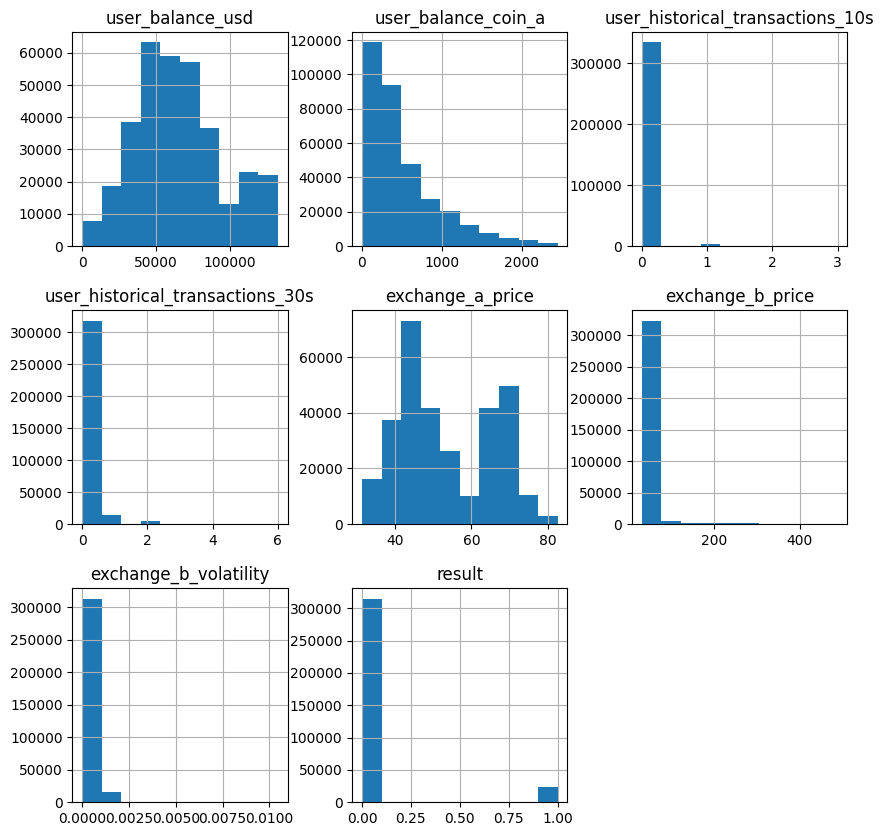

In [31]:
df.hist(figsize=(10,10))
plt.show()

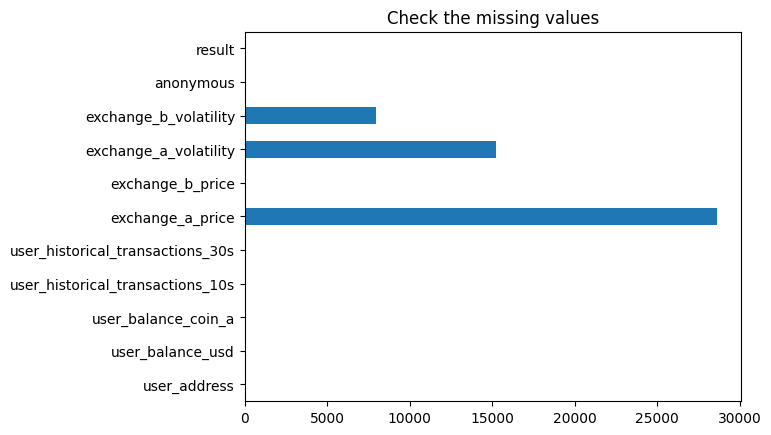

In [32]:
# Check missing values
df.isnull().sum().plot(kind='barh')
plt.title('Check the missing values')
plt.show()

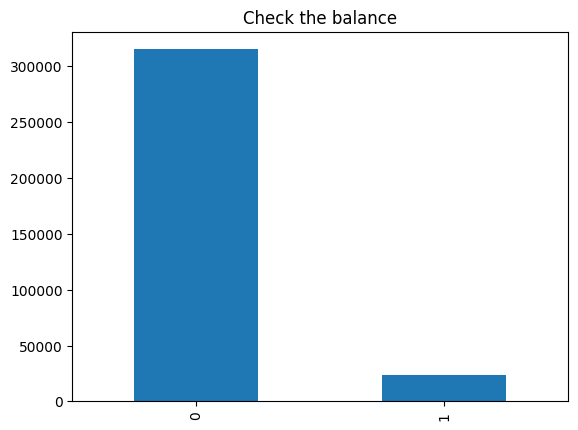

In [33]:
# check the balance
df.result.value_counts().plot(kind='bar')
plt.title('Check the balance')
plt.show()

In [34]:
df.duplicated().any()

False

# Clean data -- functions

In [35]:
def split_anonymous(data):
    
    data['anonymous_letters'] = data.anonymous.str.extract(pat = '([a-zA-Z]+)') 
    data['anonymous_numbers'] = data.anonymous.str.extract(pat= '([0123456789]+)')
        
    return data

In [36]:
# create new feature
def calculate_difference(data):
    
    data['difference'] = np.abs(data['exchange_a_price']-data['exchange_b_price'])
    
    return data

In [37]:
# ordinal encoding for categorical features
def categorical_to_number(data):
    
    order =  [{'col': 'exchange_a_volatility', 'mapping': {
        'very high'  :  1,
        'high'       :  2,
        'medium'    :   3,
        'low'     :     4,
        'very low' :    5}}]
    ordinalencoder = ce.ordinal.OrdinalEncoder(mapping=order, handle_missing=-1)
    X = data['exchange_a_volatility']
    ordinalencoder.fit(X)
    data['exchange_a_volatility'] = ordinalencoder.transform(X)
    data['exchange_a_volatility'] = data['exchange_a_volatility'].astype('int')
    
    return data

In [38]:
# Convert data type
def make_user_address_categorical(data):
    
    data['user_address'] = data['user_address'].astype('category')
    
    return data

In [39]:
# Handle Missing values
def correct_missing_values(data):
    data['exchange_a_price'].fillna(data['exchange_b_price'],inplace=True)
    data['exchange_b_price'].fillna(data['exchange_a_price'],inplace=True)
    data['exchange_b_volatility'].fillna(0,inplace=True)
    
    return data

In [40]:
# Transfomation
def transform_data(data):
    data = correct_missing_values(data)
    data = categorical_to_number(data)
    data = split_anonymous(data)
    data = calculate_difference(data)
    data = make_user_address_categorical(data)
    return data

# Clean the data

In [41]:
data = transform_data(data)
test_data = transform_data(test_data)

In [42]:
print("Are there *any* missing values in the dataframe? ", data.isnull().values.any())
print("Are there *any* missing values in the test dataframe? ", test_data.isnull().values.any())

Are there *any* missing values in the dataframe?  False
Are there *any* missing values in the test dataframe?  False


# Select data for training

In [43]:
numeric_columns = [X for X in data.columns if X not in ['user_address', 'result','anonymous_letters', 'anonymous']]
X, y = data[numeric_columns], data['result']

In [44]:
from sklearn.preprocessing import RobustScaler

rs = RobustScaler()
X_scaled = rs.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)

# Baseline model

In [65]:
model = LogisticRegression(C=0.1, penalty='l2')
model.fit(X_train, y_train)

predections = model.predict_proba(X_test)
roc_auc_score(y_test, predections[: ,1])

0.796693220160081

# Optimization 

In [52]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.0001, random_state=10, tol=0.005).fit(X_train, y_train)
predections = lasso.predict(X_test)
roc_auc_score(y_test, predections)

0.8050981391513118

# Hyperparameter Tuning

In [69]:
scipy.stats.uniform(0.1, 10)

In [70]:
from sklearn.model_selection import GridSearchCV

grid_search_parameter_space = {
    'C': [.1, 1, 4, 8, 10], 'penalty':['l2', 'l1', 'elasticnet']
}
estimator = LogisticRegression()
grid_search = GridSearchCV(estimator, grid_search_parameter_space, cv=5, scoring='roc_auc', return_train_score=True)
grid_search.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.1, 1, 4, 8, 10],
                         'penalty': ['l2', 'l1', 'elasticnet']},
             return_train_score=True, scoring='roc_auc')

In [71]:
predictions = grid_search.predict_proba(X_test)
roc_auc_score(y_test, predections[: , 1])

0.796693220160081

In [72]:
grid_search.best_score_

0.8014088507099238

# Gradient Boosting:

In [74]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(learning_rate=0.2, n_estimators=100, subsample=.5, max_depth=5, min_samples_split=700)
gb.fit(X_train, y_train)
predections = gb.predict_proba(X_test)
#predections[: ,1]
roc_auc_score(y_test, predections[: , 1])

0.8743353335189601

# Optimization 

In [75]:
from sklearn.model_selection import RandomizedSearchCV

grid_search_parameter_space = {'min_samples_split':range(400,800,100)}
estimator = GradientBoostingClassifier()
grid_search = RandomizedSearchCV(estimator, grid_search_parameter_space, cv=5, scoring='roc_auc', return_train_score=True)
grid_search.fit(X_train, y_train)


RandomizedSearchCV(cv=5, estimator=GradientBoostingClassifier(),
                   param_distributions={'min_samples_split': range(400, 800, 100)},
                   return_train_score=True, scoring='roc_auc')

In [81]:
y_preds = grid_search.predict_proba(X_test)
roc_auc_score(y_test, y_preds[: , 1])

0.8720688980868981

In [87]:
from sklearn.ensemble import RandomForestClassifier 

rf = RandomForestClassifier(min_samples_leaf=10, n_estimators=100, n_jobs=-1)
rf.fit(X_train, y_train)
y_hat = rf.predict_proba(X_test)[: ,1]
roc_auc_score(y_test, y_hat)

0.8775528121586612

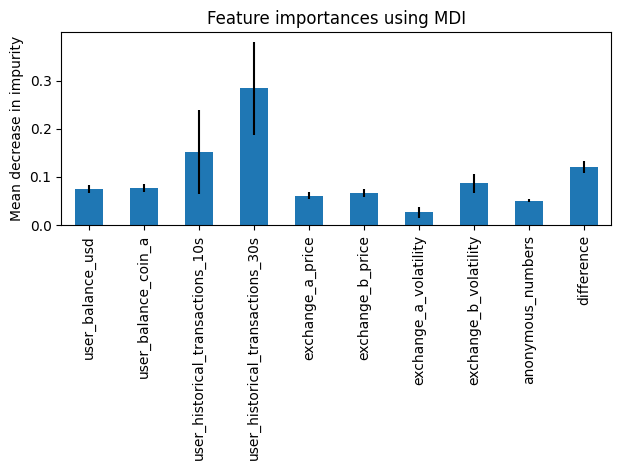

In [88]:
# check feature importances

importances = rf.feature_importances_

forest_importances = pd.Series(importances, index=numeric_columns)
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [89]:
grid_search_parameter_space = {'max_depth':range(2,10,1)}
estimator = RandomForestClassifier()
grid_search = RandomizedSearchCV(estimator, grid_search_parameter_space, cv=5, scoring='roc_auc', return_train_score=True)
grid_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(),
                   param_distributions={'max_depth': range(2, 10)},
                   return_train_score=True, scoring='roc_auc')

In [90]:
y_preds = grid_search.predict_proba(X_test)
roc_auc_score(y_test, y_preds[:, 1])

0.8724423238697127

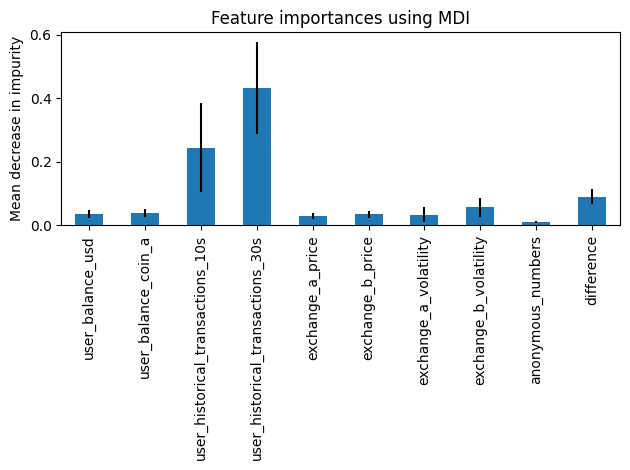

In [101]:
importances = grid_search.best_estimator_.feature_importances_

forest_importances = pd.Series(importances, index=numeric_columns)
std = np.std([tree.feature_importances_ for tree in grid_search.best_estimator_], axis=0)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [102]:
def plot_roc_curve(roc_auc, fpr, tpr):
    # Function to plot ROC Curve
    # Note: this is ALL just matplotlib stuff, nothing scientific about it! 
    
    # Inputs: 
    #     roc_auc - AU ROC value (float)
    #     fpr - false positive rate (output of roc_curve()) array
    #     tpr - true positive rate (output of roc_curve()) array
    
    plt.figure(figsize=(6,4))
    lw = 2
    plt.plot(fpr, tpr, color='orange', lw=lw, label='ROC curve (AUROC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label='random')
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.grid()
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

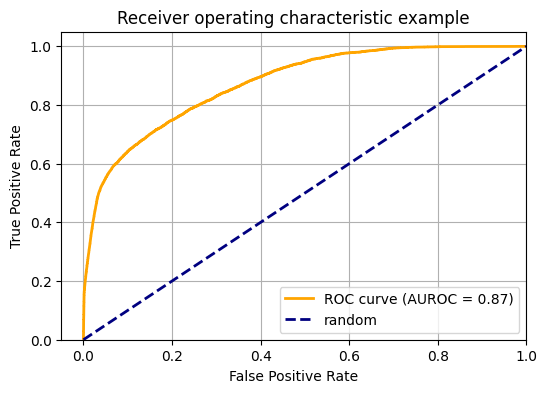

In [106]:
fpr, tpr, thresholds = roc_curve(y_score=y_preds[:, 1], y_true=y_test)
plot_roc_curve(roc_auc_score(y_test, y_preds[:, 1]), fpr, tpr)

# Submission

In [108]:
y_pred_1 = grid_search.predict_proba(rs.transform(test_data[numeric_columns]))[:, 1]
print(y_pred_1.shape)


(112830,)


In [114]:
y_pred_1

array([0.00719856, 0.78575302, 0.01694051, ..., 0.03888509, 0.04597925,
       0.03559984])

In [116]:
sample_submission = pd.read_csv('data/sample_submission.csv', index_col=0)
sample_submission.result = y_pred_1
sample_submission.to_csv('data/Portofolio.csv')